# NEURON Demonstration of the Veto Mechanism

By Charles Xu @ Caltech, 2025

For NB 150

First, install the NEURON package.

In [13]:
!pip install neuron

## Construct the neuronal model
### Morphology

We will define a simple three-compartmental neuron. The neuron comprises three cylindrical compartments:

- Dendrite: 200 µm in length, 2 µm in diameter, subdivided into 5 segments.
- Soma: 20 µm in both length and diameter, representing the spike initiation zone.
- Axon initial segment (AIS): 100 µm in length, 1 µm in diameter, subdivided into 3 segments.

The compartments are connected sequentially in the order: dendrite → soma → axon.

### Biophysics

- All compartments had axial resistance $R = 100\, \Omega \cdot \text{cm}$ and membrane capacitance $C_m = 1\, \mu F / \text{cm}^2$
- The dendrite is modeled as a purely passive cable with leak conductance $1 \times 10^{-4}\, \text{S} / \text{cm}^2$ and resting potential $E_\text{pas} = -65\, \text{mV}$.
- The soma and axon compartments included Hodgkin-Huxley dynamics (hh mechanism) to enable action potential generation and propagation.

### Input

Two types of synaptic inputs are modeled using ExpSyn mechanisms:

- An excitatory synapse (AMPA-like, $E_\text{exc} = 0\, \text{mV}$, $\tau = 2\, \text{ms}$) was placed on the dendrite at 50% of its length.
- An inhibitory synapse (GABA-like, $E_\text{inh} = -75\, \text{mV}$, $\tau = 5\, \text{ms}$) was applied at one of three locations depending on the condition:
  - Axon initial segment (AIS, 50%)
  - Soma (50%)
  - Dendrite (60%, near but more distal than the excitatory site)

In [20]:
from neuron import h, gui
import matplotlib.pyplot as plt

def run_veto_demo(inhib_target='axon', inh_delay=95, inh_weight=0.2):
    # Clear previous sections
    h('forall delete_section()')

    # Create sections
    dend = h.Section(name='dend')
    soma = h.Section(name='soma')
    axon = h.Section(name='axon')

    # Geometry
    dend.L = 200; dend.diam = 2; dend.nseg = 5
    soma.L = soma.diam = 20
    axon.L = 100; axon.diam = 1; axon.nseg = 3

    # Biophysics
    for sec in [dend, soma, axon]:
        sec.Ra = 100
        sec.cm = 1
    dend.insert('pas')
    for seg in dend: seg.pas.g = 0.0001; seg.pas.e = -65
    for sec in [soma, axon]: sec.insert('hh')

    # Connectivity
    dend.connect(soma(0))
    axon.connect(soma(1))

    # Synaptic Inputs
    exc_syn = h.ExpSyn(dend(0.5)); exc_syn.tau = 2; exc_syn.e = 0

    # Choose inhibition site
    if inhib_target == 'axon':
        inh_syn = h.ExpSyn(axon(0.5))
    elif inhib_target == 'soma':
        inh_syn = h.ExpSyn(soma(0.5))
    elif inhib_target == 'dend':
        inh_syn = h.ExpSyn(dend(0.6))  # slightly distal from EPSP
    else:
        raise ValueError("inhib_target must be 'axon', 'soma', or 'dend'")
    inh_syn.tau = 5
    inh_syn.e = -75

    # Excitatory stim
    exc_time = 20
    exc_stim = h.NetStim(); exc_stim.number = 1; exc_stim.start = exc_time
    exc_nc = h.NetCon(exc_stim, exc_syn)
    exc_nc.weight[0] = 0.1

    # Inhibitory stim
    inh_time = exc_time + inh_delay
    inh_stim = h.NetStim(); inh_stim.number = 1; inh_stim.start = inh_time
    inh_nc = h.NetCon(inh_stim, inh_syn)
    inh_nc.weight[0] = inh_weight

    # Recording
    t = h.Vector().record(h._ref_t)
    v_soma = h.Vector().record(soma(0.5)._ref_v)
    v_axon = h.Vector().record(axon(0.5)._ref_v)
    v_dend = h.Vector().record(dend(0.5)._ref_v)

    # Run
    h.finitialize(-65)
    h.tstop = 100
    h.run()

    return t, v_soma, v_axon, v_dend

Text(0, 0.5, 'Soma Vm (mV)')

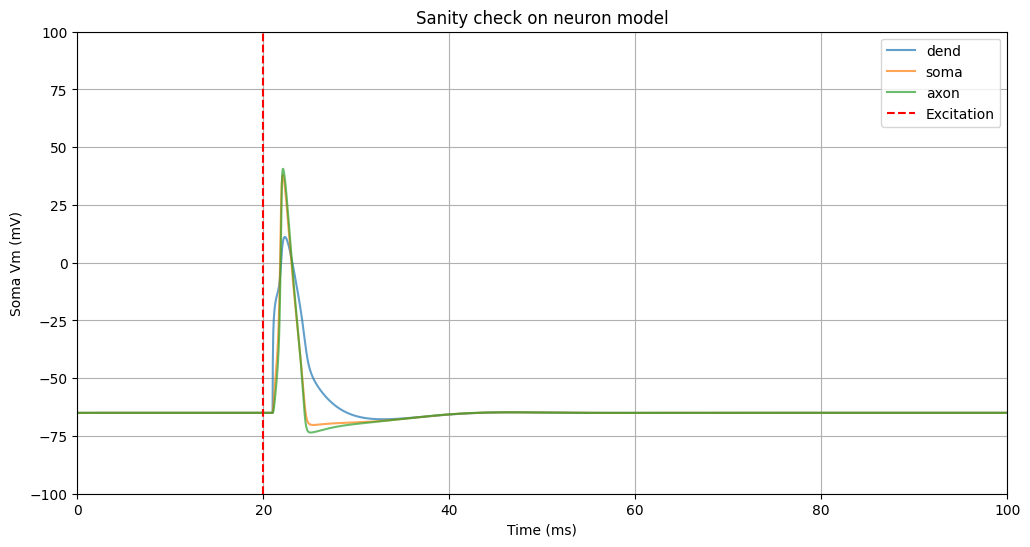

In [22]:
# Run without inhibition
compartments = ['dend', 'soma', 'axon']
inh_delay = 95
inh_weight = 0
t, v_soma, v_axon, v_dend = run_veto_demo(inhib_target='axon', inh_delay=inh_delay, inh_weight=inh_weight)

# Plot the traces
plt.figure(figsize=(12, 6))
for compartment in compartments:
    plt.plot(t, globals()[f'v_{compartment}'], label=compartment, alpha=0.7)
plt.axvline(20, color='red', linestyle='--', label='Excitation')
plt.xlim(0, 100)
plt.ylim(-100, 100)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.legend()
plt.title('Sanity check on neuron model')
plt.grid(True)
plt.xlabel('Time (ms)')
plt.ylabel('Soma Vm (mV)')

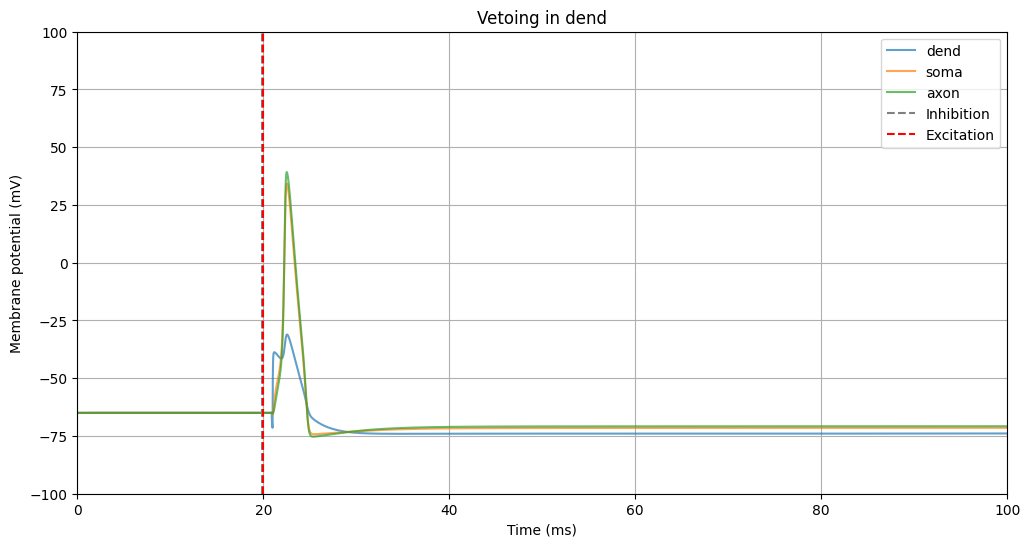

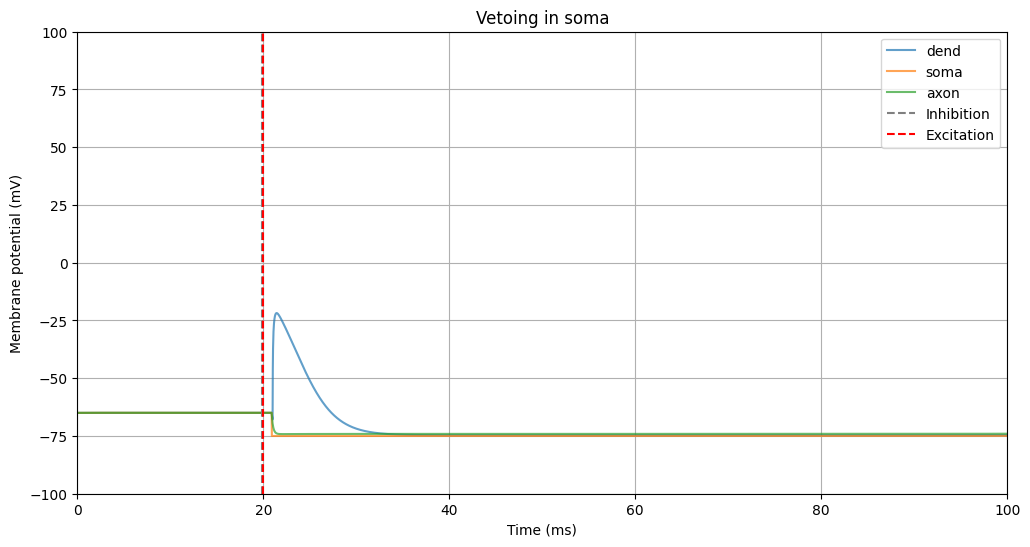

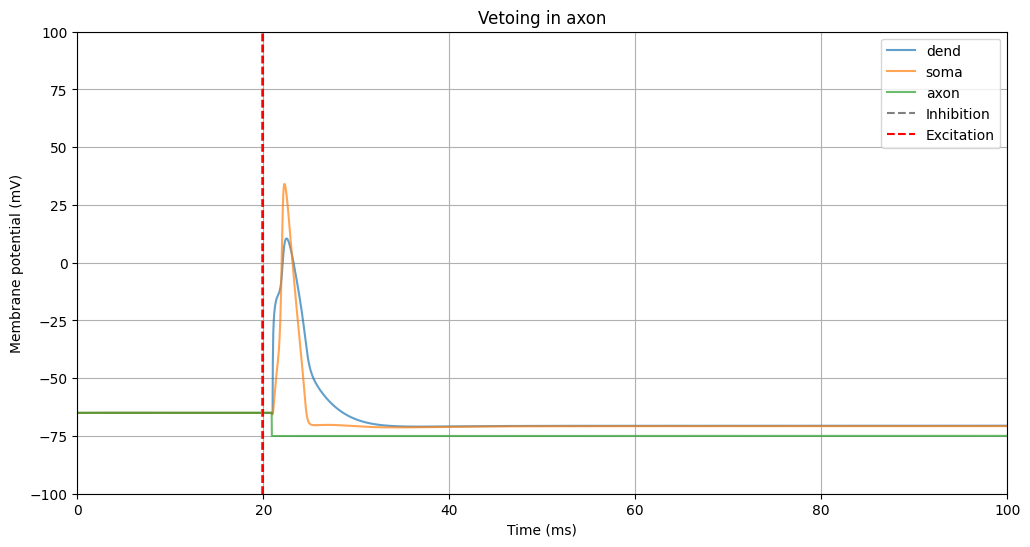

In [39]:
# Run three conditions
compartments = ['dend', 'soma', 'axon']
inh_delay = -5
inh_weight = 0.1
results = {}
for inhib_target in compartments:
    t, v_soma, v_axon, v_dend = run_veto_demo(inhib_target=inhib_target, inh_delay=inh_delay, inh_weight=inh_weight)
    results[inhib_target] = {'t': t, 'soma': v_soma, 'axon': v_axon, 'dend': v_dend}

# Plot the traces
for inhib_target in compartments:
  plt.figure(figsize=(12, 6))
  for compartment in compartments:
      plt.plot(results[inhib_target]['t'], results[inhib_target][compartment], label=compartment, alpha=0.7)
  plt.axvline(20 + inh_delay, color='gray', linestyle='--', label='Inhibition')
  plt.axvline(20, color='red', linestyle='--', label='Excitation')
  plt.xlim(0, 100)
  plt.ylim(-100, 100)
  plt.xlabel('Time (ms)')
  plt.ylabel('Membrane potential (mV)')
  plt.legend()
  plt.title(f'Vetoing in {inhib_target}')
  plt.grid(True)
  plt.show()